In [ ]:

# Exploration of DA building blocks for Lorenz 96 model
# AMF, March 2023

# Introduction
Over the next few days we will be exploring the use of different DA algorithms 
for estimating and forecasting the state of a system. To enable this, in 
today's practical we will begin by setting up an idealised system in which 
the true underlying dynamics are described by the Lorenz 96 model. From the 
true dynamics we will then generate a background and observations consistent 
with their assumed error chareteristics. This approach is known as identical 
twin experiments and allows us to fully evaluate the success of different DA 
algorithms.

First of all we need to import the functions needed.

In [1]:
import numpy as np
from tools.L96_model import lorenz96
from tools.obs import createH, gen_obs
from tools.cov import getBcanadian
from tools.plots import plotL96, plotL96obs, plotL96_Linerr, plotH, tileplotB
from tools.diag import compute_lin_error

# The Lorenz 96 model
The Lorenz 96 model describes the simplified evolution of a univariate large-scale 
atmospheric system on a one dimensional circle of latitude; simulating external 
forcing, internal dissipation and advection. It is given by 
the following equations
\begin{equation}
\frac{dx_i}{dt} = (x_{i+1} - x_{i-2})x_{i-1} - x_i + F \quad \text{for } i = 1, 2, \ldots, n \\
\end{equation}
where $x_i$ is the state variable at position $i$, and $F$ is a forcing term.

Running the next section of code will produce a Hovmoller plot of the Lorenz 
96 model when $n=12$ and $F=8$. What structures are identifiable within this plot?

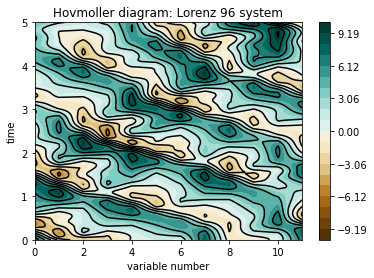

In [2]:
n      = 12     # No. of state variables (No. of nodes in Lorenz-96)
F      = 8.0    # Forcing F>5.0 guarantees chaos
deltat = 0.025  # Model timestep, 0.025 equivalent to approxiamately 3 hours
tf     = 5.0    # The final time of the simulation
t      = np.arange(0.0, tf+deltat/2, deltat)  # Set an array of the timesteps

# Set the initial conditions to something plus a perturbation
x0     = np.repeat(10.0, n)
x0[1] += 0.05

# Discard the first number of model time steps (spin-up)
discard = 150

# Call the model integration scheme and output a time sequence
xtrue  = lorenz96(x0, tf, deltat, discard, F)

# Plot the truth
plotL96(t, xtrue, n, 'Lorenz 96 system')

# Linearisation error
In many data assimilation schemes there is a strong assumption that the 
error statistics are Gaussian. This assumption is very closely linked to the 
assumption that the propogating model is linear.
The error in assuming the model is linear can be quantified in terms of how 
well the linearised (Tangent Linear) model 
acting on an increment describes the evolution of the difference between two 
non-linear runs initially separated by the same increment.
\begin{equation}
lin error(t) = ||NL({\bf x}+\Delta {\bf x},t)-NL({\bf x},t)-TL\Delta {\bf x},t||
\end{equation}
where $|| .||$ represents the L2 norm.
The size of the linearisation error will depend on the size of increment, 
$\Delta {\bf x}$, and length of the similation, $t$. Therefore, we want to find 
timescales for which the linearisation error remains small for 
the magnitude of a typical analysis increment, ${\bf x}_a-{\bf x}_b={\bf K}({\bf y}-h({\bf x}_b))$. 

In the next section of code the linearisation error is computed for the lorenz 96 model.

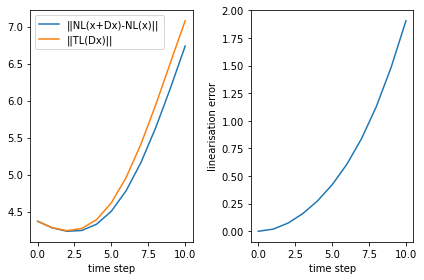

In [3]:
lin_t       = 10*deltat # length of time to compute linearisation error for 
pert   = -np.ones(n,)*np.sqrt(5/np.pi) #-np.ones(n,) #xtrue[:,2]-xtrue[:,0]# pertubation
lin_error,NLdiff,TLdiff = compute_lin_error(pert,xtrue[:,0], F, lin_t, deltat)
# plot TL and non-linear model. Compute the linearisation error as a function of time.
plotL96_Linerr(lin_error,NLdiff,TLdiff)

What does the linearisation error tell you about how frequently you need to 
observe the system?
Try changing the variable $pert\_size$. How sensitive is the linearisation to 
the magnitude and sign of the increment? What governs 
the size of increments that the linearisation error needs to be small for?

# Generation of Bmatrix
To assimilate data into the Lorenz 96 model we need to have an estimate 
of the background error covariance matrix, this should represent all sources 
of uncertainty in the background estimate. As the background generally comes from
a forecast from the previous analysis, a large source of uncertainty comes from 
the internal variability of the forecasting model. This can be estimated before
an assimilation system is in place using the 'Canadian Quick' method. This
method estimates B as the sample covariance of differneces in time lagged 
forecasts generated from a long forecast run.
\begin{equation}
\epsilon = ({\bf x}(t+T)-{\bf x}(t))/\sqrt(2)),
\end{equation}
where $T$ is the size of the time lag.

The following code estimates ${\bf B}$ using the Canadian Quick method for the Lorenz 96 model.

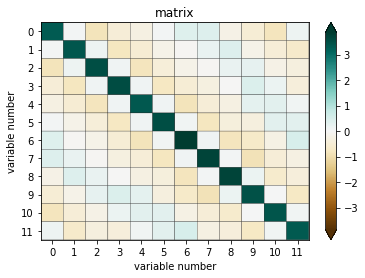

In [4]:
lag         = int(0.1/deltat) # the lag, T, in number of time steps, 
                    # 6 hours is about 0.05 time units, one period of system is about 1.8 time units
max_var     = None#2# # scales the estimated B to have a maximum variance
sample_size = 10000 # number of samples to estimate B
xB  = lorenz96(x0, sample_size*deltat, deltat, discard, F)
B,Bcorr     = getBcanadian(xB,lag,max_var,sample_size)# create a climatological matrix 
# set plot properties and then plot
mycmap      = 'BrBG'  
vs          = [-np.amax(np.diag(B)),np.amax(np.diag(B))]     
tileplotB(B,mycmap,vs)   

What does the structure of the B matrix tell you about how information in 
observations will be spread to other variables? 
How sensitive is the estimate 
of B to the lag and sample_size paramaters?

# Generation of observations
In identical twin experiments we can simulate the observations to be consistent 
with the truth (represented in the model space) given the error of the observations and the observation operator 
(the mapping from the model variables to those observed).
Four different options for the observation operator are given below:
- 'all': in which every model variable is directly observed, such that we have $n$ observations
- '1010': in which every other model variable is directly observed, such that we have $n/2$ observations
- 'landsea': in which half the domain is directly observed, such that we have $n/2$ observations
- 'foot_6': in which $p=6$ equally distributed observations measure a weighted 
    average of neighbouring grid points. This has an additional parameter 'footprint', which governs how many grid points are observed.

In the following you can also set how frequently the observations are 
available in time, and the error variance.
Running this code provides a plot of observation operator matrix, H, which 
is the same at each time that the observations are available. Each row i of 
H represents dh(x)/dx for the ith observation. Also plotted 
are the observations as a function of the observation number and the observation time. 

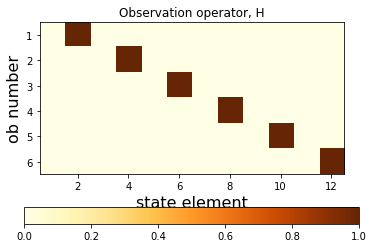

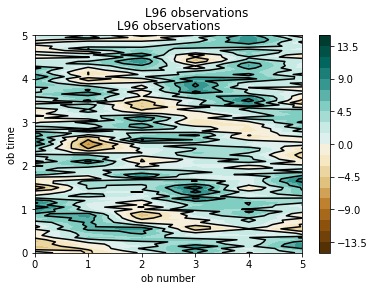

In [5]:
obsgrid     = '1010'  # 'all': observe all variables
                    # '1010': observe every other variable, 
                    # 'landsea': observe only half of domain
                    # 'foot_6': six obs of a footprint (truncated Gaussians throughout the domain)
period_obs  = 2      # number of time steps between observations
var_obs     = 2    # observation error variance
seed        = 1      # random number seed
footprint   = 3     # number of gridpoints observed by one variable for the obsgrid='foot_6'option
# Create observation operator
p, H        = createH(obsgrid,n,footprint)

# Plot the observation operator matrix
plotH(H)

# Generate the observation times, the synthetic observations, and the ob err cor matrix
tobs, y, R  = gen_obs(t, xtrue, period_obs, H, var_obs, seed)
# Plot the observations
plotL96obs(tobs, y, p, 'L96 observations')

Try different options for the obsgrid, period_obs, and var_obs. Comparing to 
the original Hovmoller plot, which options do you think provides the most 
information about the true underlying system?